In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from numpy import array
import scipy as sp
import scipy.stats as sps
from scipy.stats import norm
import math
import matplotlib as mp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import quad
import os

#Black Scholes Model for Option pricing formula

def BScallPrice(sigma,K,T,S0,r):
    d1 = (np.log(S0/K)+(r+(1/2)*sigma**2)*T)/(sigma*np.sqrt(T));
    d2 = d1-sigma*np.sqrt(T);
    c = S0*sps.norm.cdf(d1)-K*np.exp(-r*T)*sps.norm.cdf(d2);
    return (c)


def BSputPrice(sigma,K,T,S0,r):
    d1 = (np.log(S0/K)+(r+(1/2)*sigma**2)*T)/(sigma*np.sqrt(T));
    d2 = d1-sigma*np.sqrt(T);
    c = S0*sps.norm.cdf(d1)-K*np.exp(-r*T)*sps.norm.cdf(d2);
    p = c+K*np.exp(-r*T)-S0
    return (p)

In [2]:
K = 20;
S0 = 15;
sigma = 0.3;
T = 5/12;
N = 5;
r = 0.07;

CallPrice = BScallPrice(sigma, K, T, S0, r)
CallPrice

0.1391912089060625

In [3]:
PutPrice = BSputPrice(sigma,K,T,S0,r)
PutPrice

4.564282713179519

In [4]:
##2) Binomial Lattice with Cox Ross Rubinstein parametrization and number of steps N=5

N = 5

deltaT = T/N

##Lattice with Cox Ross Rubinstein u and d
u = np.exp(sigma*(deltaT**0.5))
d = np.exp(-sigma*(deltaT**0.5))
prob = (np.exp(r*deltaT)-d)/(u-d)

discount = np.exp(-r*deltaT)

#create matrice of zeros and length N+1, N+1
tabS = np.zeros((N+1, N+1))
lattice = np.zeros((N+1, N+1))

##Su Sd distribution:
for j in range(0, N+1):
    for i in np.arange(j+1):
        tabS[i, j] = S0*(u**(j-i))*d**(i) #stock price

##Filling the lattice starting from the last column
for i in range(0, N+1):
    lattice[i, N] = max(0, S0*(u**(N-i))*d**(i) - K)  # formula for a call option

for j in range(N-1, -1, -1):
    for i in range(0, j+1):
        nod1 = lattice[i, j+1]
        nod2 = lattice[i+1, j+1]
        lattice[i, j] = discount * (prob * nod1 + (1 - prob) * nod2) #option value using lattice

tabS_CRR = tabS
lattice_CRR = lattice
        
u = np.exp((r-0.5*sigma**2)*deltaT+sigma*np.sqrt(deltaT));
d = np.exp((r-0.5*sigma**2)*deltaT-sigma*np.sqrt(deltaT));
prob = 0.5;

tabS = np.zeros((N+1, N+1))
lattice = np.zeros((N+1, N+1));

##Su Sd distribution:
for j in range(0, N+1):
    for i in np.arange(j+1):
        tabS[i, j] = S0*(u**(j-i))*d**(i) #stock price

##Filling the lattice starting from the last column
for i in range(0, N+1):
    lattice[i, N] = max(0, S0*(u**(N-i))*d**(i) - K)  # formula for a call option value

for j in range(N-1, -1, -1):
    for i in range(0, j+1):
        nod1 = lattice[i, j+1]
        nod2 = lattice[i+1, j+1]
        lattice[i, j] = discount * (prob * nod1 + (1 - prob) * nod2) #option premium using lattice

df_tabS_CRR = pd.DataFrame(tabS_CRR, columns=[f'Step {x}' for x in range(N+1)])
df_lattice_CRR = pd.DataFrame(lattice_CRR, columns=[f'Step {x}' for x in range(N+1)])

print("Option Price Lattice:")
print(df_tabS_CRR)
print('\n\n')
print("Option Value Lattice:")
print(df_lattice_CRR)

Option Price Lattice:
   Step 0     Step 1     Step 2     Step 3     Step 4     Step 5
0    15.0  16.356948  17.836649  19.450209  21.209737  23.128437
1     0.0  13.755623  15.000000  16.356948  17.836649  19.450209
2     0.0   0.000000  12.614477  13.755623  15.000000  16.356948
3     0.0   0.000000   0.000000  11.567999  12.614477  13.755623
4     0.0   0.000000   0.000000   0.000000  10.608335  11.567999
5     0.0   0.000000   0.000000   0.000000   0.000000   9.728284



Option Value Lattice:
    Step 0    Step 1    Step 2    Step 3    Step 4    Step 5
0  0.10701  0.210187  0.412844  0.810899  1.592748  3.128437
1  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000
2  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000
3  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000
4  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000
5  0.00000  0.000000  0.000000  0.000000  0.000000  0.000000


In [9]:
N_ts = range(5, 501, 5)

df_binomialts_prices = pd.DataFrame(columns=['N', 'Binomial Lattice Option Price'])
df_trinomialts_prices = pd.DataFrame(columns=['N', 'Trinomial Option Price'])


def BinomialLatticeEurCall(S0, K, r, sigma, T, N):

    deltaT = T/N

    ## Cox Ross Rubinstein u and d parameters
    u=np.exp(sigma*(deltaT**0.5))
    d=np.exp(-sigma*(deltaT**0.5))
    prob=(np.exp(r*deltaT)-d)/(u-d)

    discount = np.exp(-r*deltaT)
    
    tabS = np.zeros((N+1, N+1))
    lattice = np.zeros((N+1, N+1))

    ## Su Sd distribution:
    for j in range(0, N+1):
        for i in np.arange(j+1):
            tabS[i, j] = S0*(u**(j-i))*d**(i)

    ## Filling the lattice starting from the last column
    for i in range(0, N+1):
        lattice[i, N] = max(0, S0*(u**(N-i))*d**(i)-K)  # formula for a call option

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
            nod1 = lattice[i, j+1]
            nod2 = lattice[i+1, j+1]
            lattice[i, j] = discount * (prob * nod1 + (1 - prob) * nod2)

    return lattice[0,0]


def TrinomialEuCall(S0, K, r, sigma, T, N):

    deltaT = T/N

    deltaX = sigma*deltaT**0.5; #rule of thumb
    nu = r-(1/2)*sigma**2;
    
    discount = np.exp(-r*deltaT);

    p_u = (1/2)*((sigma**2*deltaT+nu**2*deltaT**2)/deltaX**2+nu*deltaT/deltaX);
    p_m = (1-(sigma**2*deltaT+nu**2*deltaT**2)/deltaX**2);
    p_d = (1/2)*((sigma**2*deltaT+nu**2*deltaT**2)/deltaX**2-nu*deltaT/deltaX);
    pm = 1-p_u-p_d

    # set up S values (at maturity)
    Svals = np.zeros((2*N+1, 1));
    Svals[0] = S0*np.exp(N*deltaX);
    exp_dX = np.exp(-deltaX);
    
    for j in range(1, 2*N+1):
        Svals[j] = exp_dX*Svals[j-1];

    #set up lattice and terminal values
    Cvals = np.zeros((2*N+1, N+1))

    for j in range(0, 2*N+1):
        Cvals[j,N] = max(Svals[j]-K,0);

    for j in range(N-1, -1, -1):
        for i in range(N-j, N+j+1):
            Cvals[i,j] = discount*(p_u*Cvals[i-1,j+1]+p_m*Cvals[i,j+1]+p_d*Cvals[i+1,j+1]);

    price = Cvals[N,0];
    
    return price;

In [10]:
BinomialLatticeEurCall(S0, K, r, sigma, T, 1000)

0.13920293391131244

In [11]:
TrinomialEuCall(S0, K, r, sigma, T, 1000)

0.13920405860956264

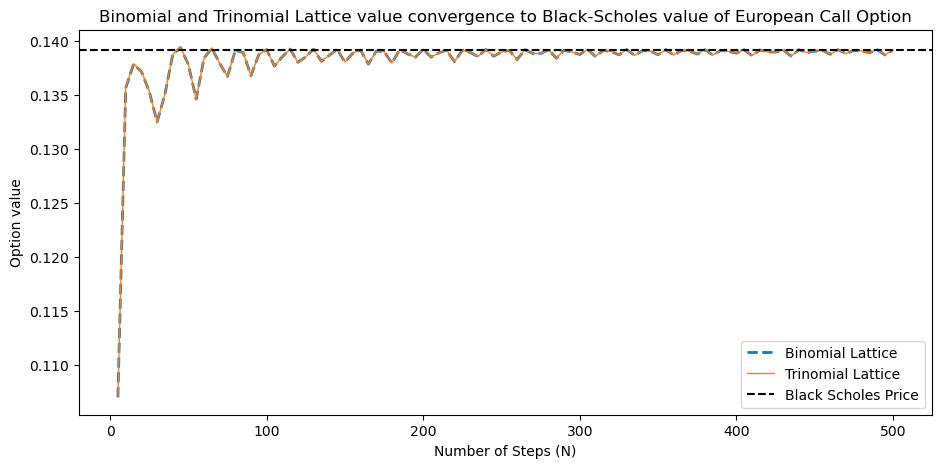

In [20]:
for n in N_ts:
    price = BinomialLatticeEurCall(S0=15, K=20, r=0.07, sigma=0.3, T=5/12, N=n)
    df_binomialts_prices = pd.concat([df_binomialts_prices, pd.DataFrame({'N': [n], 'Binomial Lattice Option Price': [price]})], ignore_index=True)
    
for n in N_ts:
    price = TrinomialEuCall(S0=15, K=20, r=0.07, sigma=0.3, T=5/12, N=n)
    df_trinomialts_prices = pd.concat([df_trinomialts_prices, pd.DataFrame({'N': [n], 'Trinomial Option Price': [price]})], ignore_index=True)
    
#df_binomialts_prices
#df_trinomialts_prices

plt.figure(figsize=(11, 5))

# Plotting binomial option values
plt.plot(df_binomialts_prices['N'], df_binomialts_prices['Binomial Lattice Option Price'], label='Binomial Lattice', linestyle=("--"), linewidth=("2"))

# Plotting trinomial option values
plt.plot(df_trinomialts_prices['N'], df_trinomialts_prices['Trinomial Option Price'], label='Trinomial Lattice', linewidth=("1"))

# Plotting Black-Scholes option values
plt.axhline(y=CallPrice, color='black', linestyle='--', label='Black Scholes Price')

plt.title('Binomial and Trinomial Lattice value convergence to Black-Scholes value of European Call Option')
plt.xlabel('Number of Steps (N)')
plt.ylabel('Option value')
plt.legend()
plt.show()

In [8]:
nabs=50
binlat_CRR=np.zeros((1,nabs))
Trinlat=np.zeros((1,nabs))

for nn in range(1, 1+nabs):
    binlat_CRR[0, nn-1] = BinomialLatticeEurCall(S0, K, r, sigma, T, 1*nn)
    Trinlat[0, nn-1] = TrinomialEuCall(S0, K, r, sigma, T, 1*nn)
    
binlat_CRR, Trinlat

(array([[0.        , 0.        , 0.13022061, 0.14152057, 0.10701026,
         0.12851865, 0.13969518, 0.11526233, 0.13742916, 0.13566011,
         0.11952642, 0.14050667, 0.12937475, 0.13573868, 0.13787215,
         0.12511702, 0.1400472 , 0.1313339 , 0.13765588, 0.13719721,
         0.13199922, 0.13962777, 0.13018207, 0.13933564, 0.13536   ,
         0.13690025, 0.13838441, 0.13278676, 0.13959276, 0.13251974,
         0.13927958, 0.13603599, 0.13769737, 0.13826362, 0.13506037,
         0.13936388, 0.13263196, 0.13948206, 0.13552889, 0.13874748,
         0.13756903, 0.13727429, 0.13883875, 0.13516274, 0.13941797,
         0.13431729, 0.1393799 , 0.13636209, 0.13879112, 0.13784731]]),
 array([[0.        , 0.        , 0.1304723 , 0.14179068, 0.10700568,
         0.12859333, 0.13983723, 0.11524506, 0.13750224, 0.13571548,
         0.1195098 , 0.140591  , 0.12937862, 0.13577112, 0.13791728,
         0.12510197, 0.14010732, 0.13133339, 0.13768501, 0.1372223 ,
         0.13199907, 0.13967752

Text(0.5, 1.0, 'Convergence of the Lattice vaue to BS value for European Call option')

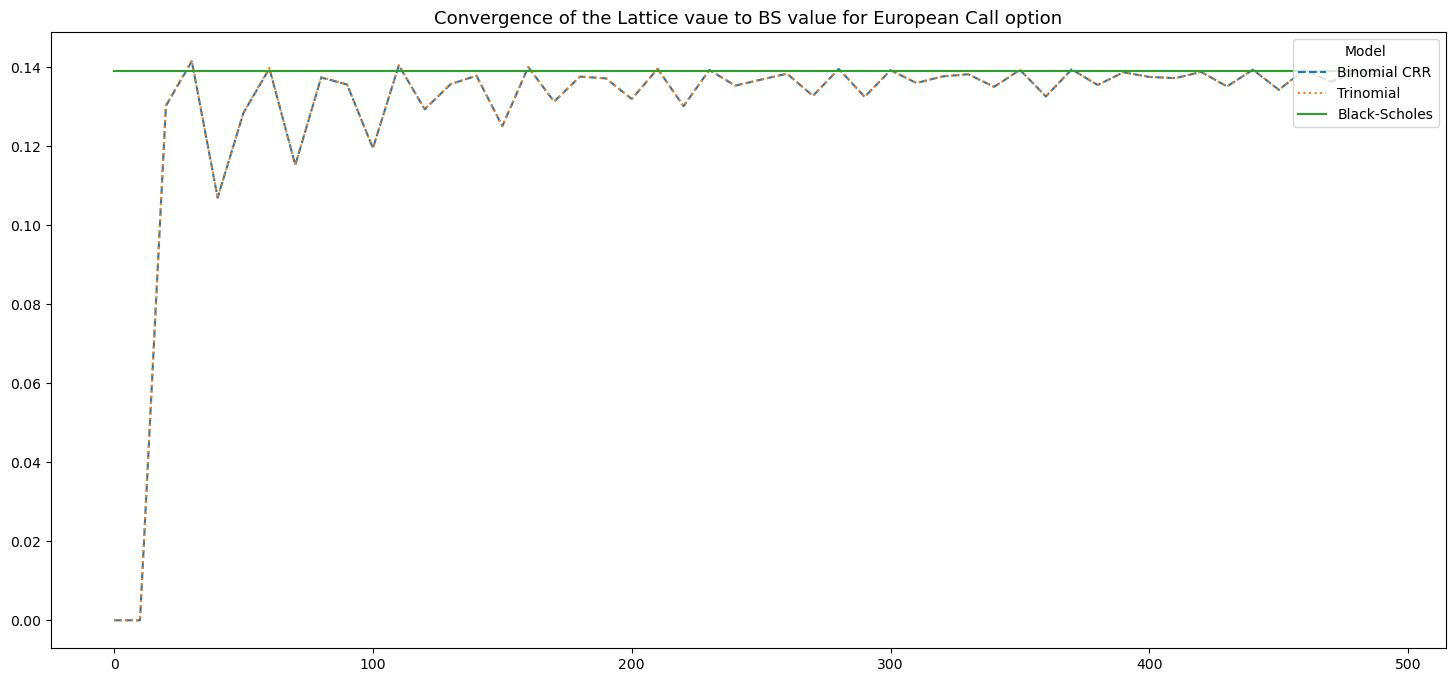

In [12]:
plt.figure(figsize=(18,8))
xax=10*np.arange(nabs)
plt.plot(xax, binlat_CRR[0], label='Binomial CRR', linestyle='dashed')
plt.plot(xax, Trinlat[0], label='Trinomial', linestyle='dotted')
plt.plot(xax, [BScallPrice(sigma,K,T,S0,r) for i in np.arange(nabs)], label='Black-Scholes')
plt.legend(title='Model', loc = 'upper right')
plt.title('Convergence of the Lattice vaue to BS value for European Call option', fontsize = 13)

In [13]:
S0 = 15
r = 0.07
sigma = 0.30


def BS_digitalCall(sigma, K, T, S0, N):
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    return (np.exp(-r*tau)*sps.norm.cdf(d2))


def BS_digitalPut(sigma,K,tau,S,r):
    d1 = (np.log(S/K)+(r+(1/2)*sigma**2)*tau)/(sigma*np.sqrt(tau));
    d2 = d1-sigma*np.sqrt(tau);
    return (np.exp(-r*tau)*sps.norm.cdf(d2))

In [14]:
##Lattice with Jarrow-Rudd u and d
def JR_BinomialLattice_EurCall(S0,K,r,sigma,T,N):
    
    deltaT = T/N
    u = np.exp((r-0.5*sigma**2)*deltaT+sigma*np.sqrt(deltaT));
    d = np.exp((r-0.5*sigma**2)*deltaT-sigma*np.sqrt(deltaT));
    pr = 0.5;

    tabS = np.zeros((N+1,N+1))
    lattice = np.zeros((N+1,N+1));

    ##Su Sd distribution:
    for j in range(0,N+1):
        for i in np.arange(j+1):
            tabS[i,j]= S0*(u**(j-i))*d**(i)

    ##filling the lattice strating by last column
    for i in range(0,N+1):
        lattice[i,N] = max(0,S0*(u**(N-i))*d**(i)-K);


    for j in range(N-1,-1,-1):
        for i in range(0,j+1):
            nod1=lattice[i,j+1]
            nod2=lattice[i+1,j+1];
            lattice[i,j] = np.exp(-r*deltaT)*(pr*nod1+(1-pr)*nod2)

    return lattice[0,0]


def JR_BinomialLattice_EurPut(S0, K, r, sigma, T, N):

    deltaT = T/N

    u = np.exp((r-0.5*sigma**2)*deltaT+sigma*np.sqrt(deltaT));
    d = np.exp((r-0.5*sigma**2)*deltaT-sigma*np.sqrt(deltaT));

    prob = 0.5

    discount = np.exp(-r*deltaT)
    
    tabS = np.zeros((N+1, N+1))
    lattice = np.zeros((N+1, N+1))

    ## Su Sd distribution:
    for j in range(0, N+1):
        for i in np.arange(j+1):
            tabS[i, j] = S0 * (u**(j-i)) * d**(i)

    ## Filling the lattice starting from the last column
    for i in range(0, N+1):
        lattice[i, N] = max(0, K - S0 * (u**(N-i)) * d**(i))  # formula for a call option

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
            nod1 = lattice[i, j+1]
            nod2 = lattice[i+1, j+1]
            lattice[i, j] = discount * (prob * nod1 + (1 - prob) * nod2)

    return lattice[0,0]

In [15]:
JR_BinomialLattice_EurCall(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=9)

0.396424592509762

In [16]:
JR_BinomialLattice_EurCall(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=188)

0.4325571092241484

In [17]:
BScallPrice(S0=15, K=20, r=0.07, sigma=0.3, T=9/12)

0.4337849838076897

In [18]:
JR_BinomialLattice_EurPut(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=9)

4.374142550080378

In [19]:
BSputPrice(S0=15, K=20, r=0.07, sigma=0.3, T=9/12)

4.410871404923714

###### European Pay-Later Options

In [21]:
def BinomialEurCallPayLater(S0, K, r, sigma, T, N, C):
    deltaT = T/N
    u = np.exp((r-0.5*sigma**2)*deltaT+sigma*np.sqrt(deltaT));
    d = np.exp((r-0.5*sigma**2)*deltaT-sigma*np.sqrt(deltaT));
    prob = 0.5;

    discount = np.exp(-r*deltaT);
    
    tabS = np.zeros((N+1,N+1))
    lattice_c = np.zeros((N+1,N+1));

    ##Su Sd distribution:
    for j in range(0,N+1):
        for i in np.arange(j+1):
            tabS[i,j] = S0*(u**(j-i))*d**(i)

    ##filling the lattice starting by last column
    for i in range(0,N+1):
        if tabS[i,j] > K:
            lattice_c[i,N] = tabS[i, N]-K-C
        else:
            lattice_c[i,N] = 0

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
                nod1 = lattice_c[i, j+1]
                nod2 = lattice_c[i+1, j+1]
                lattice_c[i, j] = discount * (prob * nod1 + (1-prob) * nod2)

    df_lattice_c = pd.DataFrame(lattice_c, columns=[f'Step_{x}' for x in range(N+1)])

    return df_lattice_c 

result_c = BinomialEurCallPayLater(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=9, C=0.4)

def BinomialEurPutPayLater(S0, K, r, sigma, T, N, C):
    deltaT = T/N
    u = np.exp((r - 0.5 * sigma**2) * deltaT + sigma * np.sqrt(deltaT))
    d = np.exp((r - 0.5 * sigma**2) * deltaT - sigma * np.sqrt(deltaT))
    prob = 0.5;

    discount = np.exp(-r*deltaT);

    tabS = np.zeros((N+1,N+1))
    lattice_p = np.zeros((N+1, N+1))

    # Su Sd distribution:
    for j in range(0, N+1):
        for i in range(j+1):
            tabS[i, j] = S0 * (u**(j-i)) * d**(i)

    # Filling the lattice starting from the last column
    for i in range(0, N+1):
        if tabS[i, j] < K:
            lattice_p[i, N] = K - tabS[i,N] - C
        else:
            lattice_p[i,N] = 0
    
    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
                nod1 = lattice_p[i, j+1]
                nod2 = lattice_p[i+1, j+1]
                lattice_p[i, j] = discount * (prob * nod1 + (1 - prob) * nod2)

    df_lattice_p = pd.DataFrame(lattice_p, columns=[f'Step_{x}' for x in range(N+1)])

    return df_lattice_p

result_p = BinomialEurPutPayLater(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=9, C=0.4)

display(result_c, result_p )

,Step_0,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9
0,0.362325,0.606039,0.995776,1.601573,2.510024,3.810691,5.562929,7.742624,10.212732,12.922174
1,0.000000,0.122851,0.223393,0.401630,0.711860,1.238727,2.103041,3.448324,5.363110,7.622787
2,0.000000,0.000000,0.023746,0.047770,0.096099,0.193323,0.388908,0.782366,1.573885,3.166186
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


,Step_0,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9
0,4.0287,3.032293,2.075023,1.221376,0.548393,0.125787,-0.026819,0.000000,0.000000,0.000000
1,0.0000,5.072247,4.025042,2.952950,1.908650,0.977416,0.279865,-0.053952,0.000000,0.000000
2,0.0000,0.000000,6.178801,5.144230,4.031802,2.862217,1.686403,0.616956,-0.108536,0.000000
3,0.0000,0.000000,0.000000,7.285667,6.316850,5.248562,4.071520,2.775583,1.349667,-0.218341
4,0.0000,0.000000,0.000000,0.000000,8.339732,7.459051,6.487016,5.415097,4.233976,2.933466
5,0.0000,0.000000,0.000000,0.000000,0.000000,9.317995,8.518363,7.634837,6.659579,5.584026
6,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,10.226655,9.501560,8.699427,7.813055
7,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.071410,10.414869,9.687590
8,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.857495,11.264009
9,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.589722


In [22]:
def BinomialEurCallPayLater(S0, K, r, sigma, T, N, C):
    deltaT = T/N
    u = np.exp((r-0.5*sigma**2)*deltaT+sigma*np.sqrt(deltaT));
    d = np.exp((r-0.5*sigma**2)*deltaT-sigma*np.sqrt(deltaT));
    prob = 0.5;

    discount = np.exp(-r*deltaT);
    
    tabS = np.zeros((N+1,N+1))
    lattice_c = np.zeros((N+1,N+1));

    ##Su Sd distribution:
    for j in range(0,N+1):
        for i in np.arange(j+1):
            tabS[i,j] = S0*(u**(j-i))*d**(i)

    ##filling the lattice starting by last column
    for i in range(0,N+1):
        if tabS[i,j] > K:
            lattice_c[i,N] = tabS[i, N]-K-C
        else:
            lattice_c[i,N] = 0

    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
                nod1 = lattice_c[i, j+1]
                nod2 = lattice_c[i+1, j+1]
                lattice_c[i, j] = discount * (prob * nod1 + (1-prob) * nod2)

    return lattice_c[0,0] 

def BinomialEurPutPayLater(S0, K, r, sigma, T, N, C):
    deltaT = T/N
    u = np.exp((r - 0.5 * sigma**2) * deltaT + sigma * np.sqrt(deltaT))
    d = np.exp((r - 0.5 * sigma**2) * deltaT - sigma * np.sqrt(deltaT))
    prob = 0.5;

    discount = np.exp(-r*deltaT);

    tabS = np.zeros((N+1,N+1))
    lattice_p = np.zeros((N+1, N+1))

    # Su Sd distribution:
    for j in range(0, N+1):
        for i in range(j+1):
            tabS[i, j] = S0 * (u**(j-i)) * d**(i)

    # Filling the lattice starting from the last column
    for i in range(0, N+1):
        if tabS[i, j] < K:
            lattice_p[i, N] = K - tabS[i,N] - C
        else:
            lattice_p[i,N] = 0
    
    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
                nod1 = lattice_p[i, j+1]
                nod2 = lattice_p[i+1, j+1]
                lattice_p[i, j] = discount * (prob * nod1 + (1 - prob) * nod2)

    return lattice_p[0,0]  

df_lattice_call = BinomialEurCallPayLater(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=9, C=0.4)
df_lattice_put = BinomialEurPutPayLater(S0=15, K=20, r=0.07, sigma=0.3, T=9/12, N=9, C=0.4)

print(f"Pay Later Binomial Lattice Call Option Value: {df_lattice_call:.4f}")
print(f"Pay Later Binomial Lattice Put Option Value: {df_lattice_put:.4f}")

Pay Later Binomial Lattice Call Option Value: 0.3623
Pay Later Binomial Lattice Put Option Value: 4.0287


In [23]:
## Implied Pay-Later Premium

#parameters
K = 20       #strike price
S0 = 15      #stock price
sigma = 0.3  #volatility
r = 0.07     #risk-free rate
T = 9/12     #Time to maturity in years
N = 9

C = 3.11

def ImpliedPremium_PL_c(S0, K, r, sigma, T, N, C):
    def fprem(C): 
        return np.sqrt((BinomialEurCallPayLater(S0, K, r, sigma, T, N, C))**2);
    x0 = BScallPrice(S0, K, r, sigma, T) #initial value
    result = sp.optimize.minimize(fprem, x0)
    return result.x
    
def ImpliedPremium_PL_p(S0, K, r, sigma, T, N, C):
    def fprem(C): 
        return np.sqrt((BinomialEurPutPayLater(S0, K, r, sigma, T, N, C))**2);
    x0 = BSputPrice(S0, K, r, sigma, T) #initial value
    
    result = sp.optimize.minimize(fprem ,x0)
    return result.x

#premium C or P that sets the pay-later option value to zero at the initial date
Cpremium = ImpliedPremium_PL_c(S0, K, r, sigma, T, N, C)
Ppremium = ImpliedPremium_PL_p(S0, K, r, sigma, T, N, C)

print(f"Implied Premium C that sets the pay-later option value to zero at the initial date: {Cpremium[0]:.4f}")
print(f"Implied Premium P that sets the pay-later option value to zero at the initial date: {Ppremium[0]:.4f}")

Implied Premium C that sets the pay-later option value to zero at the initial date: 4.6502
Implied Premium P that sets the pay-later option value to zero at the initial date: 5.0650


In [24]:
# True stock price
S_true = 15

#BS Pay Later Call
def BS_PayLaterCall(S, K, r, sigma, T):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * sps.norm.cdf(d1) - K * np.exp(-r * T) * sps.norm.cdf(d2)
    call_price1 = call_price/(np.exp(-r * T) * sps.norm.cdf(d2))
    return call_price1

#BS Pay Later put
def BS_PayLaterPut(S, K, r, sigma, T):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * sps.norm.cdf(-d2) - S * sps.norm.cdf(-d1)
    put_price1 = put_price / np.exp(-r * T) * sps.norm.cdf(-d2)
    return put_price1

#BS Pay Later premium
call_true_price = BS_PayLaterCall(S_true, K, r, sigma, T)
put_true_price = BS_PayLaterPut(S_true, K, r, sigma, T)

print(f"BS Pay Later Eur Call Option premium: {call_true_price:.4f}")
print(f"BS Pay Later Eur Put Option premium: {put_true_price:.4f}")

BS Pay Later Eur Call Option premium: 3.0416
BS Pay Later Eur Put Option premium: 3.9499


###### Plain Vanilla American Put Option

In [25]:
#Using a Binomial lattice with the Jarrow-Rudd parametrization

K = 12
S0 = 15
sigma = 0.3
r = 0.07
N = 9
T = 9/12

def JR_BinomialLattice_AmPut(S0, K, r, sigma, T, N):
    deltaT = T/N
    u = np.exp((r - 0.5 * sigma**2) * deltaT + sigma * np.sqrt(deltaT))
    d = np.exp((r - 0.5 * sigma**2) * deltaT - sigma * np.sqrt(deltaT))
    prob = 0.5

    discount = np.exp(-r*deltaT);

    tabS = np.zeros((N+1,N+1))
    lattice = np.zeros((N+1, N+1))

    # Su Sd distribution:
    for j in range(0, N+1):
        for i in range(j+1):
            tabS[i, j] = S0 * (u**(j-i)) * d**(i)

    # Filling the lattice starting from the last column
    for i in range(0, N):
            lattice[i, N] = max(0,K-S0*(u**(N-i))*d**(i));
        
    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
                nod1 = lattice[i, j+1]
                nod2 = lattice[i+1, j+1];
                hold = discount * (prob * nod1 + (1 - prob) * nod2)
                lattice[i,j] = max(hold, K-S0*(u**(j-i))*d**(i))
                
    return lattice[0,0]

# Result
am_put_option_price = JR_BinomialLattice_AmPut(S0, K, r, sigma, T, N)

print(f"American Put Option Price: {am_put_option_price:.4f}")

American Put Option Price: 0.2579


In [26]:
def BinomialLatticeAmPutPayLater(S0, K, r, sigma, T, N, P):
    deltaT = T/N
    u = np.exp((r - 0.5 * sigma**2) * deltaT + sigma * np.sqrt(deltaT))
    d = np.exp((r - 0.5 * sigma**2) * deltaT - sigma * np.sqrt(deltaT))

    prob = 0.5
    discount = np.exp(-r*deltaT);

    tabS = np.zeros((N+1,N+1))
    lattice = np.zeros((N+1, N+1));

    # Su Sd distribution:
    for j in range(0, N+1):
        for i in range(j+1):
            tabS[i, j] = S0 * (u**(j-i)) * d**(i)
    
    # Filling the lattice starting from the last column
    for i in range(0, N):
        if tabS[i, N] < K:
            lattice[i, N] = K - tabS[i, N] - P
        else:
            lattice[i, N] = 0
             
    for j in range(N-1, -1, -1):
        for i in range(0, j+1):
                nod1 = lattice[i, j+1]
                nod2 = lattice[i+1, j+1];
                hold = discount * (prob * nod1 + (1 - prob) * nod2)
                lattice[i,j] = max(K-S0*(u**(j-i))*d**(i)-P, hold)

    return lattice[0,0]

premium = 0
result = BinomialLatticeAmPutPayLater(S0, K, r, sigma, T, N, premium)
print(f"American Pay-Later Put Option Price: {result:.4f}")

American Pay-Later Put Option Price: 0.2579


In [27]:
## Implied Am Put Pay-Later Premium
    
def ImpliedAmPremium_PL_p(S0, K, r, sigma, T, N):
    def fprem(premium): 
        return np.sqrt((BinomialLatticeAmPutPayLater(S0, K, r, sigma, T, N, premium))**2);
    x0 = BS_PayLaterPut(S0, K, r, sigma, T) #initial value
    
    result = sp.optimize.minimize(fprem ,x0)
    return result.x

ztab_AmPut = pd.DataFrame(np.zeros((1,4))) #table to save the results
ztab_AmPut.rows = ('Am-Put')
ztab_AmPut.columns='Binom-months timestep', 'Binom-days timestep', 'PL Binom-months timestep', 'PL Binom-days timestep'

ztab_AmPut.iloc[0,0] = JR_BinomialLattice_AmPut(S0, K, r, sigma, T, N)
ztab_AmPut.iloc[0,1] = JR_BinomialLattice_AmPut(S0, K, r, sigma, T, N*30)

ztab_AmPut.iloc[0,2] = ImpliedAmPremium_PL_p(S0, K, r, sigma, T, N)
ztab_AmPut.iloc[0,3] = ImpliedAmPremium_PL_p(S0, K, r, sigma, T, N*30)

ztab_AmPut

,Binom-months timestep,Binom-days timestep,PL Binom-months timestep,PL Binom-days timestep
0,0.257877,0.262042,1.064015,1.49781


###### Heston model

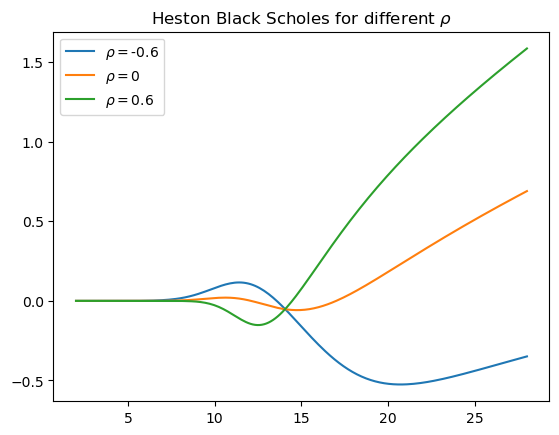

In [28]:
def Heston_function(u, param, S, tau, r, V0, type):
    kappa = param[0]
    v_bar = param[1]
    eta = param[2]
    rho = param[3]
    
    if type == 1:
        uu = 1/2;
        bb = kappa - rho*eta;
    else:
        uu = -(1/2);
        bb = kappa;
    
    aa = kappa * v_bar
    dd = np.sqrt((1j*u*rho*eta - bb)**2 - eta**2*(1j*u*2*uu - u**2));
    gg = (bb - rho*eta*u*1j + dd) / (bb - rho*eta*u*1j - dd)
    
    CC = r*u*1j*tau + aa/eta**2*((bb - rho*eta*u*1j + dd)*tau - 2*np.log((1-gg*np.exp(dd*tau))/(1-gg)));
    DD = (bb - rho*eta*u*1j + dd) / eta**2*((1-np.exp(dd*tau))/(1-gg*np.exp(dd*tau)));
    
    return np.exp(CC + DD*V0 + 1j*u*np.log(S));

def Heston_P_integrand(u, param, S, K, tau, r, V0, type):
    return np.real(np.exp(-1j*u*np.log(K)) * Heston_function(u, param, S, tau, r, V0, type)/(1j*u));

def Heston_P(u, param, S, K, tau, r, V0, type):
    integral = sp.integrate.quad(Heston_P_integrand, 0, 500, args=(param, S, K, tau, r, V0, type));
    return 1/2 + 1/np.pi * integral[0]

def HestonCall(u, param, S, K, tau, r, V0):
    # Heston model: risk neutral
    # dS/S = r*dt + sqrt(vt)*dWt
    # dvt = kappa(v_bar - vt)*dt + eta*sqrt(vt)*dZt
    # cov(dWt, dZt) = rho*dt
    call = S * Heston_P(u, param, S, K, tau, r, V0, 1) - K*np.exp(-r*tau)*Heston_P(param, S, K, tau, r, V0, 2);
    return call

def HestonPut(u, param, S, K, tau, r, V0, type):
    put = HestonCall(u, param, S, K, tau, r, V0)- S + K*np.exp(-r*tau);
    return put

def HestonPayLaterCall(param, S, K, tau, r, V0):
    bsc = S * Heston_P(u, param, S, K, tau, r, V0, 1) - K*np.exp(-r*tau)*Heston_P(u, param, S, K, tau, r, V0, 2);
    call = bsc / (np.exp(-r*tau)*Heston_P(u, param, S, K, tau, r, V0, 2))
    return call

def HestonPayLaterPut(param, S, K, tau, r, V0):
    bsp = HestonPayLaterCall(param, S, K, tau, r, V0) - S0 + K*np.exp(-r*tau);
    put = bsp / (np.exp(-r*tau)*(1 - Heston_P(u, param, S, K, tau, r, V0, 2)))
    return put

S = 15 #current stock price
sigma = 0.2 
r = 0.07 # risk-free interest rate
tau = 9/12 # time to maturity, equivalent to 9 months
T = tau # time to maturity, equivalent to 9 months
K = 12 #current strike price
kappa = 2 # mean reversion parameter
v_bar = sigma**2 # current variance
rho = 0 # correlation coefficient
V0 = sigma**2 # current variance
eta = 0.25
param = (kappa, v_bar, 0.15, 0)
difrho = np.zeros((200,3))
difeta = np.zeros((200,3))
vectK = np.linspace(2, 28, 200)
vectrho = (-0.6, 0, 0.6)
vecteta = (0.15, 0.25, 0.35)

#plotting the call option prices

for x in (0, 1, 2):
    difrho[:,x] = np.array([HestonPayLaterCall((kappa, v_bar, eta, vectrho[x]), S, vectK[i], tau, r, V0) - BS_PayLaterCall(S0, vectK[i], r, sigma, tau) for i in range(200)])
    difeta[:,x] = np.array([HestonPayLaterCall((kappa, v_bar, vecteta[x], rho), S, vectK[i], tau, r, V0) - BS_PayLaterCall(S0, vectK[i], r, sigma, tau) for i in range(200)])

for i in range(0,3):
    ro = vectrho[i];
    plt.plot(vectK, difrho[:,i], label=r'$\rho=$'+str(ro));
    plt.title("Heston Black Scholes for different $\\rho$")
    plt.legend()